# **RECOMPRA EM E-COMMERCE: XGBOOST**



### Instalação de bibliotecas

In [ ]:
# Apenas a biblioteca shap precisa ser instalada; as demais utilizadas neste notebook já vêm pré-instaladas no Google Colab
! pip install shap

### Carregamento de bibliotecas

In [2]:
from IPython.display import display
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb                                          # XGBoost
from sklearn.model_selection import KFold, cross_validate      # Validação cruzada
from sklearn.model_selection import GridSearchCV               # Otimização de hiperparâmetros via grid search
from sklearn.model_selection import RandomizedSearchCV         # Otimização de hiperparâmetros via random search
import shap                                                    # Interpretabilidade de modelos de ML

### Leitura da base de dados

In [3]:
dados_ecommerce = pd.read_table("Recompra_eCommerce.txt", sep = "\t")

### Visualização da base de dados

In [4]:
display(dados_ecommerce)

,ID_CLIENTE,IDADE,VALOR_COMPRA_SITE,QTDE_ITENS_COMPRA_SITE,FLAG_ACESSORIOS_COMPRA_SITE,FLAG_FEMININA_COMPRA_SITE,FLAG_MASCULINA_COMPRA_SITE,NOTA_SATISF_COMPRA_SITE,FLAG_COMPROU_LOJA_FISICA_6M,QTDE_COMPRAS_LOJA_FISICA_6M,QTDE_ITENS_LOJA_FISICA_6M,FLAG_RECOMPRA_PROX_3_MESES
0,1,29,185.5,2,0,1,0,7,1,4,4,1
1,2,27,215.5,2,0,1,1,7,1,2,2,1
2,3,29,106.4,4,0,1,0,10,1,1,5,1
3,4,18,140.2,1,0,1,0,8,1,1,4,0
4,5,24,72.9,2,0,1,0,7,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
1269,1270,40,165.9,6,0,1,0,8,1,3,9,1
1270,1271,33,55.6,1,0,1,0,9,0,0,0,0
1271,1272,28,105.7,4,0,0,1,6,0,0,0,0
1272,1273,28,284.9,3,0,1,1,8,0,0,0,0


### Separação de features e target

In [5]:
X = dados_ecommerce.drop(columns = ['FLAG_RECOMPRA_PROX_3_MESES', 'ID_CLIENTE'])
y = dados_ecommerce['FLAG_RECOMPRA_PROX_3_MESES']

### Criação de colunas dummy para variáveis explicativas qualitativas

In [6]:
# Não necessário para esta base de dados, pois todas as variáveis explicativas são quantitativas

### Modelo 1: XGBoost com otimização de hiperparâmetros via validação cruzada, com grid search

In [7]:
# Grid de valores dos hiperparâmetros
param_grid = {
    'n_estimators': [10, 50, 100, 200],
    'learning_rate': [0.01, 0.05, 0.1, 0.5],
    'max_depth': [2, 3, 5, 10],
    'min_child_weight': [1, 3, 5, 10],
    'gamma': [0, 0.1, 0.5, 1]
}

In [8]:
# Busca da melhor combinação de hiperparâmetros, via validação cruzada com grid search, com otimização de AUC e k = 10
xgboost = xgb.XGBClassifier(random_state = 123)
cv = KFold(n_splits = 10, shuffle = True, random_state = 123)
scoring = {'AUC': 'roc_auc', 'balanced_accuracy': 'balanced_accuracy', 'recall': 'recall'}
grid_search = GridSearchCV(xgboost, param_grid, cv = cv, scoring = scoring, refit = 'AUC')
grid_search.fit(X, y)

GridSearchCV(cv=KFold(n_splits=10, random_state=123, shuffle=True),
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     i...
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=123, ...),
             param_grid={'gamma': [0, 0.1, 0.5, 1],
                         'learning_rate': [0.01, 0.05, 0.1, 0.5],
                         'max_depth': [2, 3, 5, 10],
                         'min_child_weight': [1, 3, 5, 10],
                         'n_estimators': [10, 50, 100, 200]},
             refit='AUC',
             scoring={'AUC': 'roc_auc',
                      'balanced_accuracy': 'balanced_accuracy',
                      'recall': 'recall'})

In [9]:
# Melhor configuração de hiperparâmetros identificada
print(grid_search.best_params_)

{'gamma': 0.5, 'learning_rate': 0.1, 'max_depth': 2, 'min_child_weight': 10, 'n_estimators': 100}


In [10]:
# Tabela de desempenho com todas as combinações de hiperparâmetros testadas, ordenadas do maior para o menor AUC médio nos conjuntos de teste
resultados_grid = pd.DataFrame(grid_search.cv_results_)
resultados_grid = resultados_grid[['params',
                                   'mean_test_AUC', 'std_test_AUC', 'rank_test_AUC',
                                   'mean_test_balanced_accuracy', 'std_test_balanced_accuracy', 'rank_test_balanced_accuracy',
                                   'mean_test_recall', 'std_test_recall', 'rank_test_recall']].sort_values(by = 'rank_test_AUC')
resultados_grid

,params,mean_test_AUC,std_test_AUC,rank_test_AUC,mean_test_balanced_accuracy,std_test_balanced_accuracy,rank_test_balanced_accuracy,mean_test_recall,std_test_recall,rank_test_recall
654,"{'gamma': 0.5, 'learning_rate': 0.1, 'max_dept...",0.904867,0.022269,1,0.830360,0.026575,86,0.871708,0.040624,371
399,"{'gamma': 0.1, 'learning_rate': 0.1, 'max_dept...",0.904446,0.021984,2,0.821449,0.027146,432,0.857450,0.043575,564
143,"{'gamma': 0, 'learning_rate': 0.1, 'max_depth'...",0.904322,0.021989,3,0.821449,0.027146,432,0.857450,0.043575,564
142,"{'gamma': 0, 'learning_rate': 0.1, 'max_depth'...",0.904306,0.022863,4,0.830360,0.026575,86,0.871708,0.040624,371
398,"{'gamma': 0.1, 'learning_rate': 0.1, 'max_dept...",0.904306,0.022863,4,0.830360,0.026575,86,0.871708,0.040624,371
...,...,...,...,...,...,...,...,...,...,...
780,"{'gamma': 1, 'learning_rate': 0.01, 'max_depth...",0.850797,0.027465,1009,0.766420,0.032811,950,0.947632,0.025216,1
768,"{'gamma': 1, 'learning_rate': 0.01, 'max_depth...",0.850797,0.027465,1009,0.766420,0.032811,950,0.947632,0.025216,1
776,"{'gamma': 1, 'learning_rate': 0.01, 'max_depth...",0.850797,0.027465,1009,0.766420,0.032811,950,0.947632,0.025216,1
264,"{'gamma': 0.1, 'learning_rate': 0.01, 'max_dep...",0.850797,0.027465,1009,0.766420,0.032811,950,0.947632,0.025216,1


In [11]:
# Modelo final a partir da melhor combinação de hiperparâmetros
xgboost_1 = grid_search.best_estimator_

### Modelo 2: XGBoost com otimização de hiperparâmetros via validação cruzada, com random search

In [12]:
# Grid de valores dos hiperparâmetros
param_grid = {
    'n_estimators': np.arange(10, 201, 10),
    'learning_rate': np.arange(0.01, 0.51, 0.01),
    'max_depth': np.arange(2, 11),
    'min_child_weight': np.arange(1, 11),
    'gamma': np.arange(0, 1.1, 0.1)
}

In [13]:
# Busca da melhor combinação de hiperparâmetros, via validação cruzada com random search, com otimização de AUC e k = 10
xgboost = xgb.XGBClassifier(random_state = 123)
cv = KFold(n_splits = 10, shuffle = True, random_state = 123)
scoring = {'AUC': 'roc_auc', 'balanced_accuracy': 'balanced_accuracy', 'recall': 'recall'}
random_search = RandomizedSearchCV(xgboost, param_grid, cv = cv, scoring = scoring, refit = 'AUC', n_iter = 50, random_state = 123)
random_search.fit(X, y)

RandomizedSearchCV(cv=KFold(n_splits=10, random_state=123, shuffle=True),
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, grow_policy=None,
                                           importance_type=...
       0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43, 0.44,
       0.45, 0.46, 0.47, 0.48, 0.49, 0.5 ]),
                                        'max_depth': array([ 2,  3,  4,  5,  6,  7,  8,  9, 10]),
                                        'min_child_weight': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10]),
                                        'n_estimators': array([ 10,  20,  30,  40,  50,  60,  70,  80,  90, 100, 110, 120, 130,
       140, 150, 160, 170, 180, 190, 200])},
                   random_state=123, refit='AUC',
                   scoring={'AUC': 'roc_auc',
                            'balanced_accuracy': 'balanced_accuracy',
                            'recall': 'recall'})

In [14]:
# Melhor configuração de hiperparâmetros identificada
print(random_search.best_params_)

{'n_estimators': 130, 'min_child_weight': 9, 'max_depth': 2, 'learning_rate': 0.14, 'gamma': 0.4}


In [15]:
# Tabela com todas as combinações de hiperparâmetros testadas, ordenadas do maior para o menor AUC médio nos conjuntos de teste
resultados_grid = pd.DataFrame(random_search.cv_results_)
resultados_grid = resultados_grid[['params',
                                   'mean_test_AUC', 'std_test_AUC', 'rank_test_AUC',
                                   'mean_test_balanced_accuracy', 'std_test_balanced_accuracy', 'rank_test_balanced_accuracy',
                                   'mean_test_recall', 'std_test_recall', 'rank_test_recall']].sort_values(by = 'rank_test_AUC')
resultados_grid

,params,mean_test_AUC,std_test_AUC,rank_test_AUC,mean_test_balanced_accuracy,std_test_balanced_accuracy,rank_test_balanced_accuracy,mean_test_recall,std_test_recall,rank_test_recall
36,"{'n_estimators': 130, 'min_child_weight': 9, '...",0.903846,0.021369,1,0.826583,0.028838,5,0.864010,0.038100,8
23,"{'n_estimators': 110, 'min_child_weight': 8, '...",0.903715,0.022176,2,0.828230,0.031462,4,0.867005,0.038207,5
32,"{'n_estimators': 70, 'min_child_weight': 10, '...",0.902227,0.023364,3,0.824804,0.027422,8,0.854878,0.037529,13
49,"{'n_estimators': 180, 'min_child_weight': 8, '...",0.902127,0.020330,4,0.824343,0.033073,9,0.864805,0.046470,6
44,"{'n_estimators': 10, 'min_child_weight': 4, 'm...",0.902075,0.018894,5,0.813724,0.030949,42,0.856333,0.040141,12
8,"{'n_estimators': 190, 'min_child_weight': 1, '...",0.901361,0.021077,6,0.831305,0.031006,2,0.871439,0.045246,3
35,"{'n_estimators': 70, 'min_child_weight': 2, 'm...",0.900846,0.022982,7,0.814279,0.028595,41,0.846345,0.028356,21
13,"{'n_estimators': 60, 'min_child_weight': 2, 'm...",0.900842,0.022358,8,0.826204,0.033427,6,0.846908,0.045775,20
30,"{'n_estimators': 120, 'min_child_weight': 8, '...",0.900834,0.021985,9,0.821981,0.030195,16,0.854160,0.041994,14
16,"{'n_estimators': 180, 'min_child_weight': 3, '...",0.900697,0.019585,10,0.815585,0.026425,32,0.835371,0.040371,37


In [16]:
# Modelo final a partir da melhor combinação de hiperparâmetros
xgboost_2 = random_search.best_estimator_

### Estimativa de desempenho do modelo 1 em dados totalmente apartados, via validação cruzada aninhada

In [17]:
# Grid de valores dos hiperparâmetros
param_grid = {
    'n_estimators': [10, 50, 100, 200],
    'learning_rate': [0.01, 0.05, 0.1, 0.5],
    'max_depth': [2, 3, 5, 10],
    'min_child_weight': [1, 3, 5, 10],
    'gamma': [0, 0.1, 0.5, 1]
}

In [18]:
# Validação cruzada aninhada com grid search e otimização de AUC, k1 = 3 e k2 = 5
xgboost = xgb.XGBClassifier(random_state = 123)
inner_cv = KFold(n_splits = 3, shuffle = True, random_state = 123)
outer_cv = KFold(n_splits = 5, shuffle = True, random_state = 123)

scoring = {'AUC': 'roc_auc', 'balanced_accuracy': 'balanced_accuracy', 'recall': 'recall'}
grid_search = GridSearchCV(xgboost, param_grid, cv = inner_cv, scoring = scoring, refit = 'AUC')
nested_scores = cross_validate(grid_search, X = X, y = y, cv = outer_cv, scoring = scoring)

In [19]:
# AUC das melhores configurações de hiperparâmetros identificados da camada interna (maximizando AUC), nos k1 conjuntos de teste da camada externa
print(nested_scores['test_AUC'].round(3))
print("Média de AUC: " + str(round(np.mean(nested_scores['test_AUC']), 3)))
print("D.P. de AUC: " + str(round(np.std(nested_scores['test_AUC']), 3)))

[0.892 0.901 0.92  0.9   0.919]
Média de AUC: 0.906
D.P. de AUC: 0.011


In [20]:
# Acurácia balanceada das melhores configurações de hiperparâmetros identificados da camada interna (maximizando AUC), nos k1 conjuntos de teste da camada externa
print(nested_scores['test_balanced_accuracy'].round(3))
print("Média de Acurácia Balanceada: " + str(round(np.mean(nested_scores['test_balanced_accuracy']), 3)))
print("D.P. de Acurácia Balanceada: " + str(round(np.std(nested_scores['test_balanced_accuracy']), 3)))

[0.811 0.815 0.849 0.839 0.85 ]
Média de Acurácia Balanceada: 0.833
D.P. de Acurácia Balanceada: 0.017


In [21]:
# Sensibilidade das melhores configurações de hiperparâmetros identificados da camada interna (maximizando AUC), nos k1 conjuntos de teste da camada externa
print(nested_scores['test_recall'].round(3))
print("Média de Sensibilidade: " + str(round(np.mean(nested_scores['test_recall']), 3)))
print("D.P. de Sensibilidade: " + str(round(np.std(nested_scores['test_recall']), 3)))

[0.838 0.858 0.876 0.911 0.891]
Média de Sensibilidade: 0.875
D.P. de Sensibilidade: 0.025


### Estimativa de desempenho do modelo 2 em dados totalmente apartados, via validação cruzada aninhada

In [22]:
# Grid de valores dos hiperparâmetros
param_grid = {
    'n_estimators': np.arange(10, 201, 10),
    'learning_rate': np.arange(0.01, 0.51, 0.01),
    'max_depth': np.arange(2, 11),
    'min_child_weight': np.arange(1, 11),
    'gamma': np.arange(0, 1.1, 0.1)
}

In [23]:
# Validação cruzada aninhada com random search e otimização de AUC, k1 = 3 e k2 = 5
xgboost = xgb.XGBClassifier(random_state = 123)
inner_cv = KFold(n_splits = 3, shuffle = True, random_state = 123)
outer_cv = KFold(n_splits = 5, shuffle = True, random_state = 123)

scoring = {'AUC': 'roc_auc', 'balanced_accuracy': 'balanced_accuracy', 'recall': 'recall'}
random_search = RandomizedSearchCV(xgboost, param_grid, cv = inner_cv, scoring = scoring, refit = 'AUC', n_iter = 50, random_state = 123)
nested_scores = cross_validate(random_search, X = X, y = y, cv = outer_cv, scoring = scoring)

In [24]:
# AUC das melhores configurações de hiperparâmetros identificados da camada interna (maximizando AUC), nos k1 conjuntos de teste da camada externa
print(nested_scores['test_AUC'].round(3))
print("Média de AUC: " + str(round(np.mean(nested_scores['test_AUC']), 3)))
print("D.P. de AUC: " + str(round(np.std(nested_scores['test_AUC']), 3)))

[0.888 0.901 0.919 0.901 0.919]
Média de AUC: 0.906
D.P. de AUC: 0.012


In [25]:
# Acurácia balanceada das melhores configurações de hiperparâmetros identificados da camada interna (maximizando AUC), nos k1 conjuntos de teste da camada externa
print(nested_scores['test_balanced_accuracy'].round(3))
print("Média de Acurácia Balanceada: " + str(round(np.mean(nested_scores['test_balanced_accuracy']), 3)))
print("D.P. de Acurácia Balanceada: " + str(round(np.std(nested_scores['test_balanced_accuracy']), 3)))

[0.803 0.819 0.853 0.817 0.846]
Média de Acurácia Balanceada: 0.828
D.P. de Acurácia Balanceada: 0.019


In [26]:
# Sensibilidade das melhores configurações de hiperparâmetros identificados da camada interna (maximizando AUC), nos k1 conjuntos de teste da camada externa
print(nested_scores['test_recall'].round(3))
print("Média de Sensibilidade: " + str(round(np.mean(nested_scores['test_recall']), 3)))
print("D.P. de Sensibilidade: " + str(round(np.std(nested_scores['test_recall']), 3)))

[0.846 0.865 0.876 0.867 0.891]
Média de Sensibilidade: 0.869
D.P. de Sensibilidade: 0.015


### Aplicação do modelo final de XGBoost na base de dados



In [27]:
# Aplicação do modelo (cálculo das probabilidades preditas)
y_prob = xgboost_1.predict_proba(X)[:,1]

In [28]:
# Definição de ponto de corte
ponto_corte = y.astype(int).mean()

In [29]:
# Atribuição da categoria predita
dados_ecommerce['y_pred'] = (y_prob >= ponto_corte).astype(int)

### Importância das features do modelo final

In [30]:
# Cálculo de medida de importância de Gini
importancias = xgboost_1.feature_importances_
features = X.columns

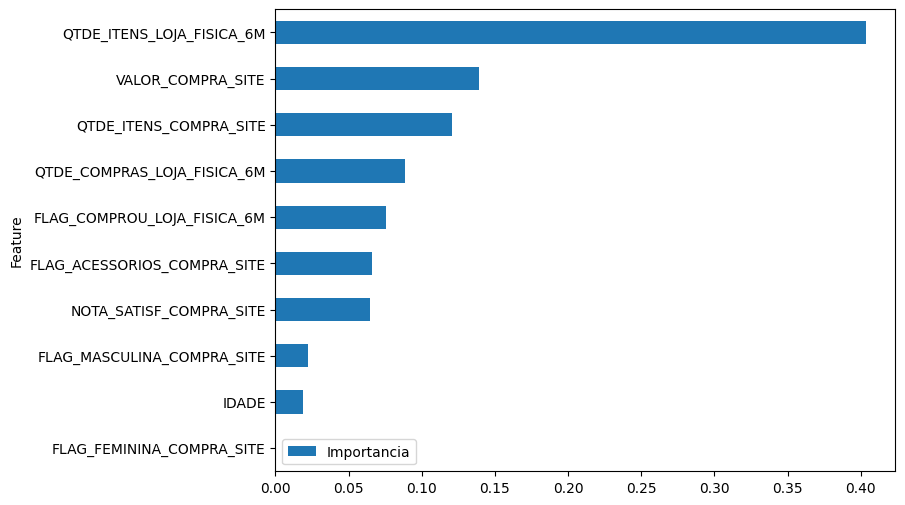

In [31]:
# Gráfico das importâncias de Gini
df_importancias = pd.DataFrame({'Feature': features, 'Importancia': importancias}).sort_values(by = 'Importancia', ascending = True)
df_importancias.plot.barh(x = 'Feature', y = 'Importancia', figsize = (8, 6))
plt.show()

In [43]:
# Cálculo de valores SHAP para as observações
explainer = shap.Explainer(xgboost_1)
valores_shap = explainer(X)

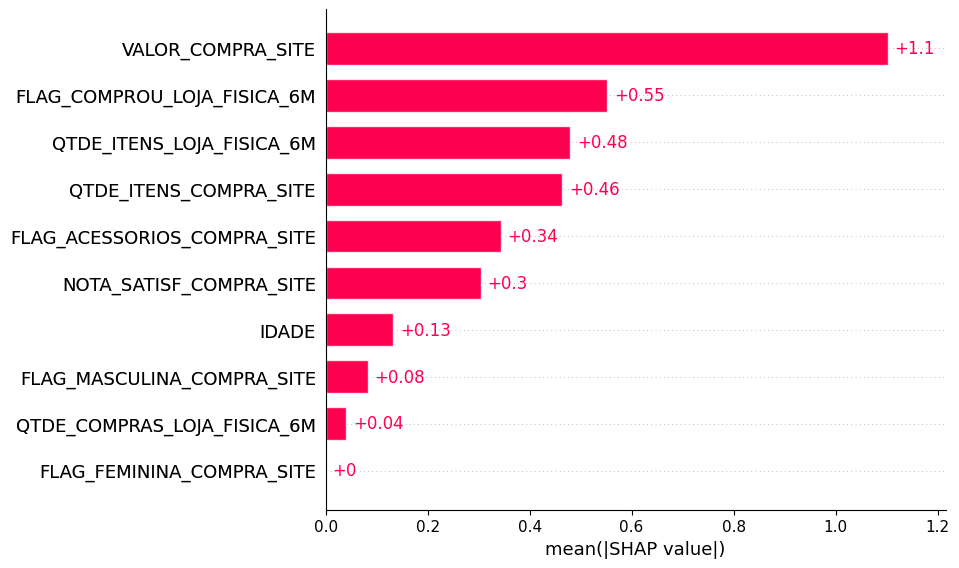

In [44]:
# Gráfico do SHAP absoluto médio por feature
shap.plots.bar(valores_shap)

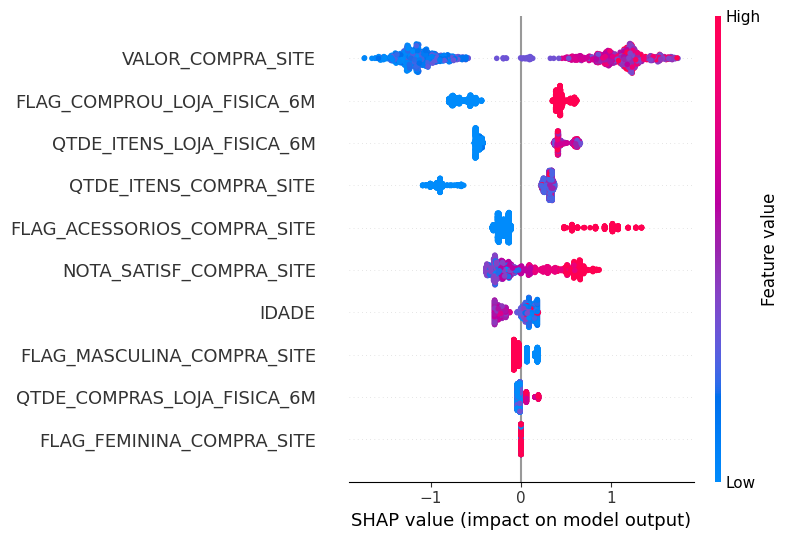

In [45]:
# Gráfico de distribuição de valores SHAP por feature: "enxame de abelhas" (beeswarm plot)
shap.summary_plot(valores_shap)